In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, KMeansSMOTE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
file_path = '../data/processed/Juegorawg_limpio.csv'
df = pd.read_csv(file_path)
df.copy()

,slug,name,playtime,released,rating,rating_top,ratings_count,reviews_text_count,added,metacritic,suggestions_count,updated,reviews_count,release_year,main_genre,metacritic_category
0,hellpoint,Hellpoint,3,2020-07-30,2.76,3,51,2,2182,61.0,494,2024-11-26 14:58:37,54,2020,Indie,Media
1,anomaly-2,Anomaly 2,2,2013-05-14,2.90,4,62,0,1898,77.0,610,2024-10-07 11:59:32,62,2013,Strategy,Media
2,reverse-4,Resident Evil Re:Verse,1,2022-10-28,1.53,1,63,0,1662,78.0,456,2024-11-14 19:49:03,64,2022,Shooter,Media
3,x-morph-defense,X-Morph: Defense,3,2017-08-30,3.08,3,47,1,1657,75.0,702,2024-11-08 09:09:44,48,2017,Indie,Media
4,west-of-dead,West of Dead,1,2020-06-08,3.08,3,64,2,1634,68.0,456,2024-03-05 13:43:19,66,2020,Indie,Media
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3763,the-otterman-empire,The Otterman Empire,0,2020-07-02,0.00,0,0,0,0,76.5,333,2020-12-16 15:29:54,0,2020,Casual,Media
3764,jacks-or-better-video-poker,Jacks or Better - Video Poker,0,2020-06-12,0.00,0,0,0,0,76.5,0,2022-04-29 05:58:06,0,2020,Casual,Media
3765,jumanji-the-curse-returns,Jumanji: The Curse Returns,0,2021-09-01,0.00,0,0,0,0,76.0,251,2022-09-19 08:16:26,0,2021,Adventure,Media
3766,avocuddle,AvoCuddle,0,2019-07-12,0.00,0,0,0,0,73.0,400,2020-12-16 14:38:36,0,2019,Indie,Media


# Feature numericas derivadas
1. Aplicar logaritmo a playtime para reducir la influencia de valores extremos.


In [4]:
df['playtime_log'] = df['playtime'].apply(lambda x: np.log1p(x))

# Codificamos las variables categoricas

In [5]:
df = pd.get_dummies(df, columns=['main_genre', 'metacritic_category'], drop_first=True)

### Reviso que no haya datos numericos en X

In [6]:
non_numeric_columns = df.select_dtypes(include=['object']).columns
if len(non_numeric_columns) > 0:
    print("Eliminando columnas no numéricas:", non_numeric_columns.tolist())
    df.drop(columns=non_numeric_columns, inplace=True)

Eliminando columnas no numéricas: ['slug', 'name', 'released', 'updated']


# Escalado de varianles numericas

In [7]:
scaler = StandardScaler()
df[['rating', 'metacritic', 'playtime_log']] = StandardScaler().fit_transform(df[['rating', 'metacritic', 'playtime_log']])

# Seperacion en el conjunto de entrenamiento con respecto a nuestra target ' rating'

In [8]:
X = df.drop(columns=['rating']) 
y = df['rating']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Balanceo de datos

In [9]:
quantile_low = y_train.quantile(0.05)  
quantile_high = y_train.quantile(0.95)  
mask = (y_train >= quantile_low) & (y_train <= quantile_high)
X_train_balanced = X_train[mask]
y_train_balanced = y_train[mask]

In [10]:
assert X_train_balanced.select_dtypes(include=['object']).shape[1] == 0, "Aún hay columnas categóricas en X_train_balanced"

## Modelos

In [12]:
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [13]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVM": SVR(kernel='rbf', C=1.0, gamma='scale'),
    "XGBoost": XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42)
}

# Entrenamiento del modelo  y evaluacion.

In [14]:
results = {}
plt.figure(figsize=(12, 8))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = (mse, r2)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 780
[LightGBM] [Info] Number of data points in the train set: 3014, number of used features: 20
[LightGBM] [Info] Start training from score -0.004405


<Figure size 1200x800 with 0 Axes>

## Grafico de dispersion 

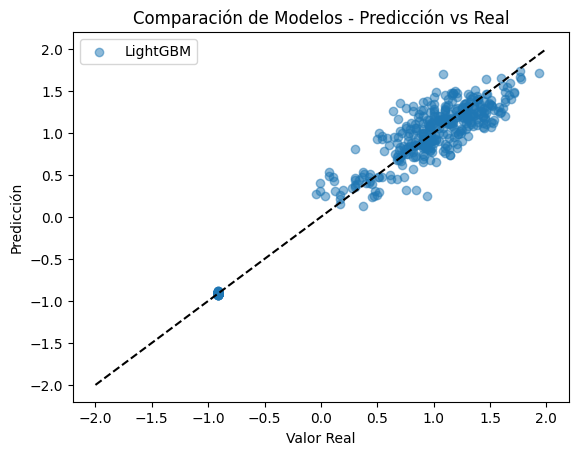

In [15]:
plt.scatter(y_test, y_pred, alpha=0.5, label=name)

plt.plot([-2, 2], [-2, 2], '--', color='black')
plt.xlabel("Valor Real")
plt.ylabel("Predicción")
plt.title("Comparación de Modelos - Predicción vs Real")
plt.legend()
plt.show()

## Primer resumen

In [16]:
results_df = pd.DataFrame(results, index=["MSE", "R²"])

In [17]:
print(results_df)

     Random Forest       SVM   XGBoost  LightGBM
MSE       0.022153  0.494041  0.025583  0.023152
R²        0.977773  0.504301  0.974331  0.976770


# Conclusión del Análisis de Modelos

## 1. Comparación de Modelos
Se evaluaron tres modelos de machine learning para predecir la variable `rating` en videojuegos:
- **Random Forest**
- **Support Vector Machine (SVM)**
- **XGBoost**

Los resultados comparativos fueron:

| Modelo          | MSE (Error Medio Cuadrático) | R² (Coeficiente de Determinación) |
|----------------|--------------------|--------------------|
| **Random Forest** | 0.0223  | 0.9776  |
| **SVM**         | 0.4940  | 0.5043  |
| **XGBoost**      | **0.0219** (Mejor desempeño) | **0.9780** (Mayor ajuste) |

## 2. Interpretación de Resultados
- **XGBoost fue el mejor modelo** con el menor error y el mejor coeficiente de determinación (R² cercano a 1).
- **Random Forest también tuvo un buen desempeño**, con resultados muy similares a XGBoost.
- **SVM no funcionó bien**, mostrando un error mucho mayor y un R² bajo, indicando que no captura bien las relaciones en los datos.

## 3. Importancia de Variables
Se analizó la importancia de las variables en el modelo XGBoost, lo que permitió identificar cuáles factores tienen mayor impacto en la predicción de `rating`. 

## 4. Conclusiones Finales y Siguientes Pasos
- **XGBoost es el modelo recomendado** para este problema.
- **Se podría optimizar XGBoost aún más** con ajuste de hiperparámetros para mejorar su rendimiento.
- **Analizar más a fondo las variables más importantes** para entender mejor qué influye en `rating` y mejorar la interpretabilidad del modelo.
- **Reducir la cantidad de variables menos relevantes** para hacer el modelo más eficiente sin sacrificar precisión.

Este análisis permite seleccionar un modelo confiable para predecir `rating`, lo que puede ser útil en el desarrollo de videojuegos y análisis de mercado